## Data Preparation

In [21]:
pip install transformers

     |████████████████████████████████| 4.0 MB 15.0 MB/s 
     |████████████████████████████████| 880 kB 11.2 MB/s 
     |████████████████████████████████| 6.6 MB 57.5 MB/s 
     |████████████████████████████████| 77 kB 6.9 MB/s 
     |████████████████████████████████| 596 kB 58.3 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=86721684ee6b779d5caf35d7d9e97449dff9ce858b83b1bc4af69ac9c28f1203
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [22]:
import keras

import pandas as pd
import numpy as np
import torch

from transformers import BertTokenizer, BertModel
from scipy.spatial.distance import cosine

import nltk
from nltk.corpus import stopwords

from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

from keras.layers import Embedding, Dropout, Convolution1D, LSTM, SimpleRNN, merge, Dense
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import re
from sklearn.model_selection import train_test_split

import requests
import os

In [23]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


Have 2112 reviews available.

In [100]:
AAPL_news=pd.read_csv('/content/drive/MyDrive/DeepL_27_Final Project/new files/News.csv', encoding='latin-1')
AAPL_news = AAPL_news.dropna(axis=1)
AAPL_news['date'] = pd.to_datetime(AAPL_news.date)
# AAPL_news['headline'].dtypes#objects
AAPL_news#2112 rows

,headline,date
0,Today's Scuttlebot: Piracy Negotiations and Ap...,2012-06-01
1,"Rounding Up Apple Conference Chatter, From Map...",2012-06-05
2,Google Schools Apple on Maps,2012-06-06
3,Cricket to Offer a No-Contract iPhone,2012-06-06
4,App Smart Extra: What Apple and Google Get Right,2012-06-07
...,...,...
2107,Apple's Zipped Lips on Chips,2022-04-19
2108,Apple Store workers in Atlanta are the first t...,2022-04-20
2109,"Apple's growth slows, but still beats Wall Str...",2022-04-28
2110,How Technocrats Triumphed at Apple,2022-05-01


In [101]:
AAPL = pd.read_csv("/content/drive/MyDrive/DeepL_27_Final Project/AAPL_20120601.csv")
AAPL['Date'] = pd.to_datetime(AAPL.Date)#2495 rows. We get more price data than news
AAPL#2495 rows

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-06-01,20.327143,20.451786,20.018572,20.035357,17.155760,520987600
1,2012-06-04,20.053572,20.267857,19.589287,20.153214,17.256672,556995600
2,2012-06-05,20.045357,20.231071,19.940357,20.101070,17.212030,388214400
3,2012-06-06,20.277500,20.494642,20.196428,20.409286,17.475946,401455600
4,2012-06-07,20.617500,20.618570,20.375000,20.418571,17.483902,379766800
...,...,...,...,...,...,...,...
2490,2022-04-25,161.119995,163.169998,158.460007,162.880005,162.880005,96046400
2491,2022-04-26,162.250000,162.339996,156.720001,156.800003,156.800003,95623200
2492,2022-04-27,155.910004,159.789993,155.380005,156.570007,156.570007,88063200
2493,2022-04-28,159.250000,164.520004,158.929993,163.639999,163.639999,130216800


In [102]:
AAPL_news = AAPL_news[AAPL_news.date.isin(AAPL.Date)]
AAPL_news#1881 rows
AAPL = AAPL[AAPL.Date.isin(AAPL_news.date)]
AAPL#1086 rows

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-06-01,20.327143,20.451786,20.018572,20.035357,17.155760,520987600
2,2012-06-05,20.045357,20.231071,19.940357,20.101070,17.212030,388214400
3,2012-06-06,20.277500,20.494642,20.196428,20.409286,17.475946,401455600
4,2012-06-07,20.617500,20.618570,20.375000,20.418571,17.483902,379766800
5,2012-06-08,20.414286,20.735001,20.321428,20.725714,17.746891,347516400
...,...,...,...,...,...,...,...
2475,2022-04-01,174.029999,174.880005,171.940002,174.309998,174.309998,78699800
2479,2022-04-07,171.160004,173.360001,169.850006,172.139999,172.139999,77594700
2486,2022-04-19,165.020004,167.820007,163.910004,167.399994,167.399994,67723800
2487,2022-04-20,168.759995,168.880005,166.100006,167.229996,167.229996,67929800


In [103]:
# Calculate the difference in closing prices between the following and current day.
# The model will try to predict how much the Close value will change based on the news.
AAPL = AAPL.set_index('Date').diff(periods=1)
AAPL['Date'] = AAPL.index
AAPL = AAPL.reset_index(drop=True)
# Remove unneeded features
# AAPL = AAPL.drop(['High','Low','Close','Volume','Adj Close'], 1)

# AAPL.head(10)# several null values on the top

#Remove top row since it has a null value.
AAPL = AAPL[AAPL.Close.notnull()]
# AAPL['Close'].dtypes#float64
AAPL

,Open,High,Low,Close,Adj Close,Volume,Date
1,-0.281786,-0.220715,-0.078215,0.065713,0.056270,-132773200.0,2012-06-05
2,0.232143,0.263571,0.256071,0.308216,0.263916,13241200.0,2012-06-06
3,0.340000,0.123928,0.178572,0.009285,0.007956,-21688800.0,2012-06-07
4,-0.203214,0.116431,-0.053572,0.307143,0.262989,-32250400.0,2012-06-08
5,0.575714,0.282856,0.058214,-0.326784,-0.279814,243748400.0,2012-06-11
...,...,...,...,...,...,...,...
1081,-3.809997,-3.149994,-2.459992,-0.300003,-0.300003,-24349500.0,2022-04-01
1082,-2.869995,-1.520004,-2.089996,-2.169999,-2.169999,-1105100.0,2022-04-07
1083,-6.140000,-5.539994,-5.940002,-4.740005,-4.740005,-9870900.0,2022-04-19
1084,3.739991,1.059998,2.190002,-0.169998,-0.169998,206000.0,2022-04-20


In [104]:
# Create a list of the close prices and their corresponding daily headlines from the news
price = []
headlines = []

for row in AAPL.iterrows():
    daily_headlines = []
    date = row[1]['Date']
    price.append(row[1]['Close'])
    for row_ in AAPL_news[AAPL_news.date==date].iterrows():
        daily_headlines.append(row_[1]['headline'])
    
    # Track progress
    headlines.append(daily_headlines)
    if len(price) % 500 == 0:
        print(len(price))

print(len(price))#1085
print(len(headlines))#1085

500
1000
1085
1085


In [105]:
print(max(len(i) for i in headlines))# max number of headlines for each day is 11
print(min(len(i) for i in headlines))# min number of headlines for each day is 1

11
1


## Stock Price Normalization

In [30]:
# Normalize close prices (target values)
max_price = max(price)
min_price = min(price)
mean_price = np.mean(price)
def normalize(price):
    return ((price-min_price)/(max_price-min_price))
#another way of return: %change:（current price - previous day price）/ (previous day price)

In [31]:
norm_price = []
for p in price:
    norm_price.append(normalize(p))

In [32]:
# Check that normalization worked well
print(min(norm_price))
print(max(norm_price))
print(np.mean(norm_price))

0.0
1.0
0.4955411410050316


## News Headline preprocess and GloVe for word embedding

### Split Data

In [107]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(headlines,norm_price,test_size=0.2,random_state=0)
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


In [108]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [109]:
# Number of words to consider as features
max_features = 1000
# Cut texts after this number of words 
# (among top max_features most common words)
maxlen = 60
batch_size = 10

#Tokenizing headlines
tokenizer=Tokenizer(max_features,oov_token="<?>")
tokenizer.fit_on_texts(x_train)
X_train=tokenizer.texts_to_sequences(x_train)# X_train with upper case "X" is tokenized, x_train with lower case "x" is not

word_index = tokenizer.word_index # This part is important for pre-trained embedding
print('Found %s unique tokens.' % len(word_index))

X_test=tokenizer.texts_to_sequences(x_test)
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

# This turns our lists of integers
# into a 2D integer tensor of shape `(samples, maxlen)`
print('Pad sequences (samples x text length)')
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

Found 1495 unique tokens.
868 train sequences
217 test sequences
Pad sequences (samples x text length)
X_train shape: (868, 60)
X_test shape: (217, 60)


In [70]:
# y_train.shape[0]

### GloVe Download and loading

In [110]:
# Optional code for glove download 
file_url = "http://nlp.stanford.edu/data/glove.6B.zip"
    
r = requests.get(file_url, stream = True)  

if not os.path.exists("glove.6B.zip"):
  print("Downloading...")
  with open("glove.6B.zip", "wb") as file:  
    for block in r.iter_content(chunk_size = 1024): 
      if block:  
        file.write(block)  
else:
  print("Archive file already existed. Delete the original zip file if you want to re-download")


print("Uncompressing...")
!unzip 'glove.6B.zip'

Archive file already existed. Delete the original zip file if you want to re-download
Uncompressing...
Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [40]:
# Load GloVe's embeddings

glove_dir = '/content/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))#can change the txt file
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [111]:
embedding_dim = 100 #This value should match the number before "d.txt", which means that it has to be 100 if the glove embedding is 100d.txt

embedding_matrix = np.zeros((max_features, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_features:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

### Build Model with Conv1D

In [112]:
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
model = Sequential()
model.add(layers.Embedding(max_features, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(16, 5, activation='tanh'))
model.add(layers.MaxPooling1D(10))
model.add(layers.Conv1D(32, 5, activation='tanh'))
model.add(layers.GlobalMaxPooling1D())
model.add(Dense(1))

# we are adding our pretrained weights from glove here. 
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 100)           100000    
                                                                 
 conv1d (Conv1D)             (None, 56, 16)            8016      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5, 16)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 32)             2592      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 3

In [113]:
model.compile(optimizer='adam', loss='mae', metrics='mape')
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=batch_size,
                    validation_data=(X_test,y_test))
keras.backend.clear_session()
del model

Epoch 1/10
87/87 [==============================] - 1s 7ms/step - loss: 0.0983 - mape: 584475.6250 - val_loss: 0.0247 - val_mape: 5.2566
Epoch 2/10
87/87 [==============================] - 1s 9ms/step - loss: 0.0308 - mape: 569144.9375 - val_loss: 0.0265 - val_mape: 5.8224
Epoch 3/10
87/87 [==============================] - 1s 6ms/step - loss: 0.0308 - mape: 578881.8125 - val_loss: 0.0257 - val_mape: 5.4488
Epoch 4/10
87/87 [==============================] - 1s 7ms/step - loss: 0.0316 - mape: 577454.6250 - val_loss: 0.0239 - val_mape: 5.1213
Epoch 5/10
87/87 [==============================] - 1s 8ms/step - loss: 0.0305 - mape: 551388.1250 - val_loss: 0.0237 - val_mape: 5.1721
Epoch 6/10
87/87 [==============================] - 0s 4ms/step - loss: 0.0315 - mape: 556615.9375 - val_loss: 0.0235 - val_mape: 5.0615
Epoch 7/10
87/87 [==============================] - 0s 4ms/step - loss: 0.0315 - mape: 561892.7500 - val_loss: 0.0238 - val_mape: 5.1879
Epoch 8/10
87/87 [=======================

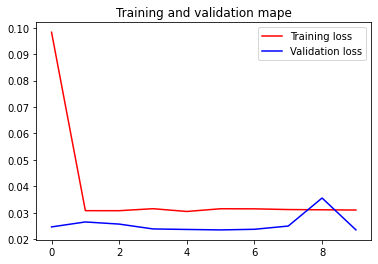

In [114]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation mape')
plt.legend()

plt.show()